In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
import kagglehub
import os

warnings.filterwarnings('ignore')
tf.random.set_seed(42)

# Download latest version
path = kagglehub.dataset_download("shashwatwork/android-malware-dataset-for-machine-learning")

print("Path to dataset files:", path)
path = os.path.join(path, "drebin-215-dataset-5560malware-9476-benign.csv")
df_malware = pd.read_csv(path)

2025-06-24 12:03:12.220299: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 12:03:12.233038: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 12:03:12.339175: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 12:03:12.447051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750746792.559277   28483 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750746792.60

Path to dataset files: /home/drunkencloud/.cache/kagglehub/datasets/shashwatwork/android-malware-dataset-for-machine-learning/versions/1


In [2]:
df_malware['class'] = df_malware['class'].apply(lambda x: 0 if x == 'S' else 1)
y = df_malware['class']
X = df_malware.drop('class', axis=1)

nan_columns = X.columns[X.isnull().any()].tolist()
if nan_columns:
    imputer = SimpleImputer(strategy='mean')
    X[nan_columns] = imputer.fit_transform(X[nan_columns])

non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    X = X.drop(columns=non_numeric_cols)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

E0000 00:00:1750746800.225749   28483 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1750746800.227274   28483 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


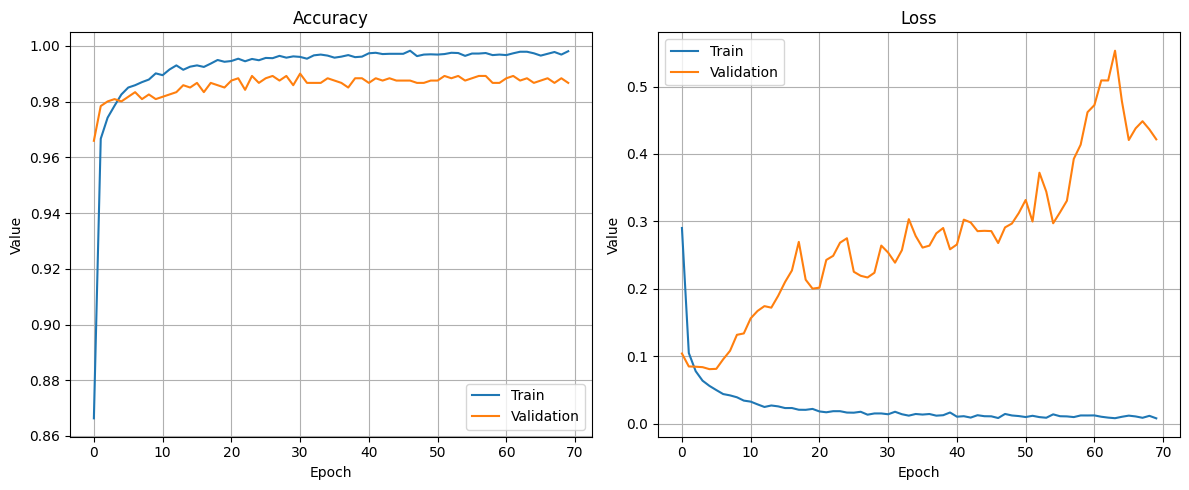

In [3]:

model_malware = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_malware.compile(optimizer=Adam(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history_malware = model_malware.fit(X_train, y_train,
                                    epochs=70,
                                    batch_size=64,
                                    validation_split=0.1,
                                    verbose=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_malware.history['accuracy'])
plt.plot(history_malware.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_malware.history['loss'])
plt.plot(history_malware.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.tight_layout()
plt.show()

Loss: 0.0663
Accuracy: 0.9900
Precision: 0.9890
Recall: 0.9953

Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.98      0.99      1112
     Malware       0.99      1.00      0.99      1896

    accuracy                           0.99      3008
   macro avg       0.99      0.99      0.99      3008
weighted avg       0.99      0.99      0.99      3008



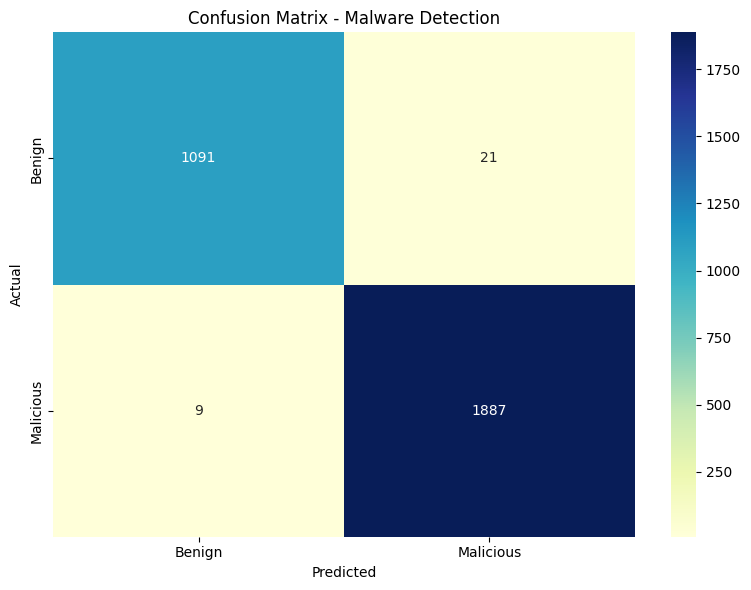

In [4]:
loss_m, accuracy_m, precision_m, recall_m = model_malware.evaluate(X_test, y_test, verbose=0)

y_pred_proba_m = model_malware.predict(X_test, verbose=0)
y_pred_m = (y_pred_proba_m > 0.5).astype(int)

cm_m = confusion_matrix(y_test, y_pred_m)
cr_m = classification_report(y_test, y_pred_m, target_names=['Benign', 'Malware'])

print(f"Loss: {loss_m:.4f}")
print(f"Accuracy: {accuracy_m:.4f}")
print(f"Precision: {precision_m:.4f}")
print(f"Recall: {recall_m:.4f}")
print("\nClassification Report:\n", cr_m)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix - Malware Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()